<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History

## V0.0.1 
* One-hot encoding (based on first class)
* Predictions based on softmax (no extra hidden layer of MobileNetV2)
* Optimizer='rmsprop', Loss='categorical_crossentropy'

## V0.0.2
* Added extra hidden layer of 1024 nodes
* Accuracy never rises above 74% (depends on which class is selected as first class)

## V0.0.3
* Added multi-label targets
* Changed output layer to 'sigmoid' activation function
* Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
* Changed the metric to categorical_accuracy

## V0.0.4
* Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits
-> doesn't make things better

## V0.0.5
* Using TruePositives, TrueNegatives, FalsePositives, FalseNegatives, TopKCategoricalAccuracy(k=1) as metric
* Added fine tuning of last 55 layers of the base model

## V0.0.6
* Split training and test as was done for the VOC dataset
* Removed from_logits = True
* Switched to BinaryCrossentropy instead of CategoricalCrossentropy
* Used Adam optimiser

## V0.0.7
* Using learning rate LR = 1e-5

## V0.0.8
* Doubled the number of epochs to 20
* Rescaled the data to [-1,1] -> did not seem to have a positive effect

## V0.0.9
* Added Macro F1 as a metric

## V0.0.10
* Increased learning rate to 1e-4 for the first learning part

## V0.0.11
* Added model training from scratch
* Added data augmentation
* Added inspection of the training data
* Added inspection of the model results

## V0.0.12
* Cleaned up code

In [0]:
# This parameter will indicate if the models in this section will be trained, or the .h5 file for the model will be read instead.
model_train = False

## Create the dataset

Some imports that will be needed in this part.

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

Retrieve the VOC2009 dataset and unpack it.

In [3]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



File ‘VOCtrainval_11-May-2009.tar’ already there; not retrieving.

Total bytes read: 935536640 (893MiB, 34MiB/s)


We will retrieve the image names for the training and validation set.

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
trainImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','train.txt')
valImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','val.txt')
trainImageNames = np.loadtxt(trainImageNamesFile, dtype='str')
valImageNames = np.loadtxt(valImageNamesFile, dtype='str')

In the dataset, every image is associated with 1 or more classes, as defined in the variable 'CLASSES' in the code below. There are 20 classes in total. To be able to use a set of classes as the output of our model later on, we will encode a set of classes using a vector of 20 numbers: 0 when that particular class is not present in the image, 1 if it is.

In [0]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss

This way, we can encode a class array such as ['bicycle', 'bus', 'chair'] as the vector [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] as can be seen below.

In [6]:
a = encode(['bicycle', 'bus', 'chair'])
print(a)
print(decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


For every image, there is an .xml file indicating the classes (and their bounding boxes) in the image. We don't need the bounding boxes in this case, so we just keep a list of the classes that appear in the image and encode this list as was configured above.
Every image is also transformed:
* The image is resized to (224,224,3) - a format that is needed for the CNN model later on
* The image pixel values are rescaled to [-1,1], which is also needed for the CNN model later on



In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
# The resulting shape of the images - needed for the CNN models
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    
    # Read the xml file that accompanies the image and extract the detected objects
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    
    # Read the image, resize it to the correct shape and scale the pixel values to [-1,1]
    image = io.imread(os.path.join(image_folder,imageName + ".jpg"))
    image = (image/127.5) - 1
    image = resize(image, IMG_SHAPE)
    
    # Add the encoded object array and the image to the results
    targets.append(encode(objects))
    images.append(image)
  return (np.array(images).astype('float32'),np.array(targets))

The training and validation dataset are created based on the image names defined in the VOC2009 train/validation list.

In [0]:
x_train, y_train = createDataSet(trainImageNames)
x_val, y_val = createDataSet(valImageNames)

Next, we create a tensorflow Dataset that will be used to train our models later on. The data will be shuffled and divided into batches. The training dataset will be augmented as well: every image will be randomly flipped left/right and for every image the contrast and brightness will be randomly adjusted. This will help in preventing our models from overfitting on the training set.

In [0]:
def augment(image,label):
  # Change pixel values from [-1,1] to [0,1] to do the image manipulation
  image = (image+1)/2
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.2, 0.5)
  image = tf.image.random_brightness(image, max_delta=0.5) 
  # Change pixel values back from [0,1] to [-1,1]
  image = image * 2 - 1
  return image,label

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(augment).shuffle(len(x_train)//2).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

## Explore the dataset

Let's explore some of the images and their labels. The images often have a different aspect ratio then (224,224), but we need this shape for the CNN we are going to use further on. This is why some of the images seem a little bit 'squeezed'.
The CNN networks that will be used later on, require the input to be in the range [-1,1], but the 'imshow' command requires the pixel values to be in the range [0,1]. This why we need to do some compution before showing the image.

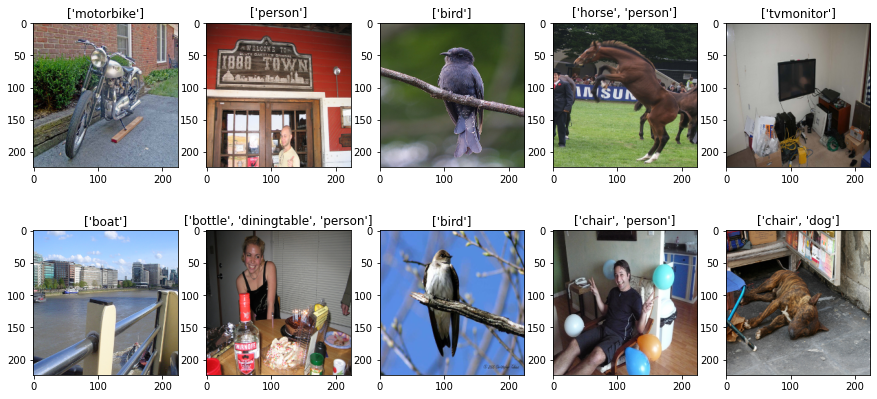

In [11]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx] + 1)/2)
  plt.title(decode(y_train[idx]))
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  plt.title(decode(y_val[idx]))

To get a better overview of the data, we will plot the number of times a certain class appears in the dataset. We see that the category 'Person' is overrepresented in the dataset, which will influence the learning later on. Classes such as 'Sheep' or 'Cow' are less present.

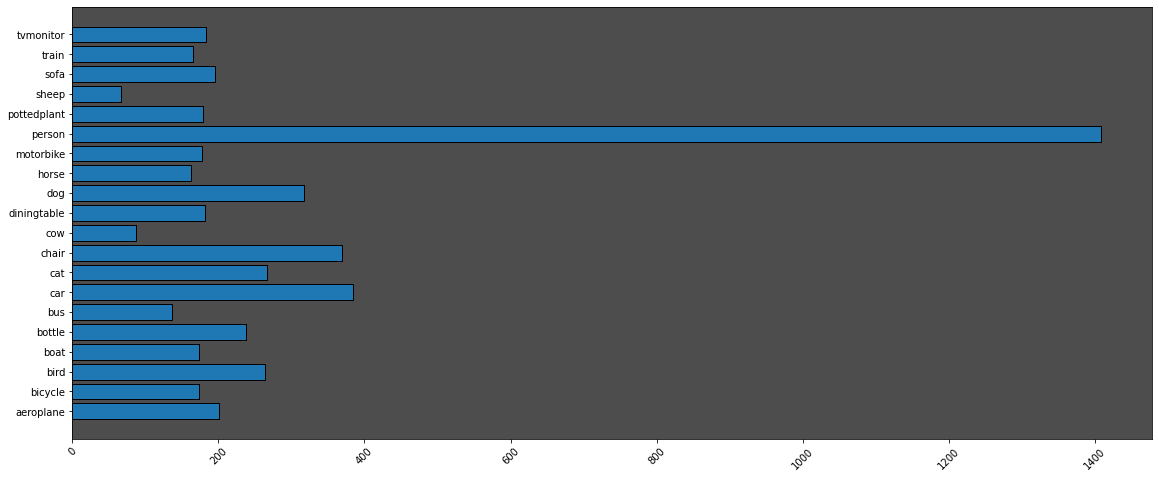

In [12]:
targetSum = np.sum(y_train, axis=0)
fig = plt.figure(figsize=(15, 6))
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, targetSum, linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

## Training the CNN models

We will train 2 CNN models. The first model will be created and trained from scratch. For the second model will be using transfer learning. We need a metric to validate the accuracy of our models. Since we are training the models for a multi-label classification problem, the F1 score seems a good metric. The F1 score considers both the precision and the recall and has a maximum value of 1. In this case we calculate the mean F1 score across all the classes. This will help us later on as well to see differences in prediction accuracy across the classes. We will also keep track of the true positives, false positives, true negatives and false negatives. For the F1 score, we implement a custom metric.

In [0]:
class MacroF1(tf.keras.metrics.Metric):

    # Initialize all the weights 
    def __init__(self, name='macro_f1', **kwargs):
      super(MacroF1, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', shape=(20), initializer='zeros')
      self.false_positives = self.add_weight(name='fp', shape=(20), initializer='zeros')
      self.true_negatives = self.add_weight(name='tn', shape=(20), initializer='zeros')
      self.false_negatives = self.add_weight(name='fn', shape=(20), initializer='zeros')
      self.f1 = self.add_weight(name='f1', shape=(20), initializer='zeros')

    # Update the state of the weigths based on the new predictions
    def update_state(self, y_true, y_pred):
      y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
      # count the number of true positives
      tp = tf.cast(tf.math.count_nonzero(y_pred * y_true, axis=0), tf.float32)
      # count the number of false positives
      fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_true), axis=0), tf.float32)
      # count the number of true negatives
      tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y_true), axis=0), tf.float32)
      # count the number of false negatives
      fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_true, axis=0), tf.float32)
      self.true_positives.assign_add(tp)
      self.false_positives.assign_add(fp)
      self.true_negatives.assign_add(tn)
      self.false_negatives.assign_add(fn)

    # Calculate the resulting F1 score
    def result(self):
      f1 = 2*self.true_positives / (2*self.true_positives + self.false_negatives + self.false_positives + 1e-16)
      self.f1.assign(f1)
      macro_f1 = tf.reduce_mean(f1)
      return macro_f1

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(np.zeros(20))
      self.false_positives.assign(np.zeros(20))
      self.true_negatives.assign(np.zeros(20))
      self.false_negatives.assign(np.zeros(20))
      self.f1.assign(np.zeros(20))

### Train model from scratch

For the first model (the CNN trained from scratch), we will use a much simpler architecture then the one we will use for transfer learning later on. This is because we have a limited amount of data available, so we want to limit the complexity and the number of parameters in the model.
For this model we will use a series of convolution and maxpooling layers. Our input shape is (224,224,3). The convolutional layers will learn specific filters. The maxpooling layers will pool the results, downsizing the dimensions, as well as providing some basic translation invariance.
After the convolutional layers, we add a 'Flatten' layer to create one long vector of 6400 features, fully connected to the next layer of 64 hidden nodes to actually do the classification in the last Dense layer with 20 nodes, representing the 20 classes we want to predict. We are using a 'sigmoid' activation function, because we want a separate prediction for each class for every image (we are doing multilabel classification) as opposed to using a softmax layer when we only want to predict 1 label per image.
Next to data augmentation, we add some additional measures to prevent overfitting: before the dense layers we add a dropout layer, which randomly sets input units to 0. We also add a L2 regularizer to the dense layer with 64 hidden nodes. 

In [0]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model1.add(tf.keras.layers.Dense(20, activation='sigmoid'))

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

We will compile this model. We will use the Adam optimizer with a learning rate of 1e-4 and the metrics we discussed before (including our custom F1 score). The binary crossentropy loss is used, since there are a number of outputs that each predict true/false for that specific label. If there would be only 1 label for each input, 'CategoricalCrossentropy' could have been used.

In [0]:
LR = 1e-4
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

We will train this model for 120 epochs on our training data

In [17]:
epochCount = 120
history = model1.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/120
35/35 [==============================] - 11s 328ms/step - loss: 0.4771 - macro_f1: 0.0484 - true_positives: 473.0000 - true_negatives: 60618.0000 - false_positives: 3514.0000 - false_negatives: 4855.0000 - val_loss: 0.3937 - val_macro_f1: 0.0119 - val_true_positives: 255.0000 - val_true_negatives: 65864.0000 - val_false_positives: 372.0000 - val_false_negatives: 5129.0000
Epoch 2/120
35/35 [==============================] - 10s 288ms/step - loss: 0.3785 - macro_f1: 0.0158 - true_positives: 344.0000 - true_negatives: 63713.0000 - false_positives: 419.0000 - false_negatives: 4984.0000 - val_loss: 0.4432 - val_macro_f1: 7.1336e-04 - val_true_positives: 11.0000 - val_true_negatives: 66216.0000 - val_false_positives: 20.0000 - val_false_negatives: 5373.0000
Epoch 3/120
35/35 [==============================] - 10s 288ms/step - loss: 0.3545 - macro_f1: 0.0144 - true_positives: 294.0000 - true_negatives: 63794.0000 - false_positives: 338.0000 - false_negatives: 5034.0000 - val_loss

Let's plot the evolution of the loss and F1 scores during training. In terms of the loss, we clearly see the model overfitting on the training set after about 50 epochs. In terms of the F1-score, the F1-score seems to remain around 0.2.

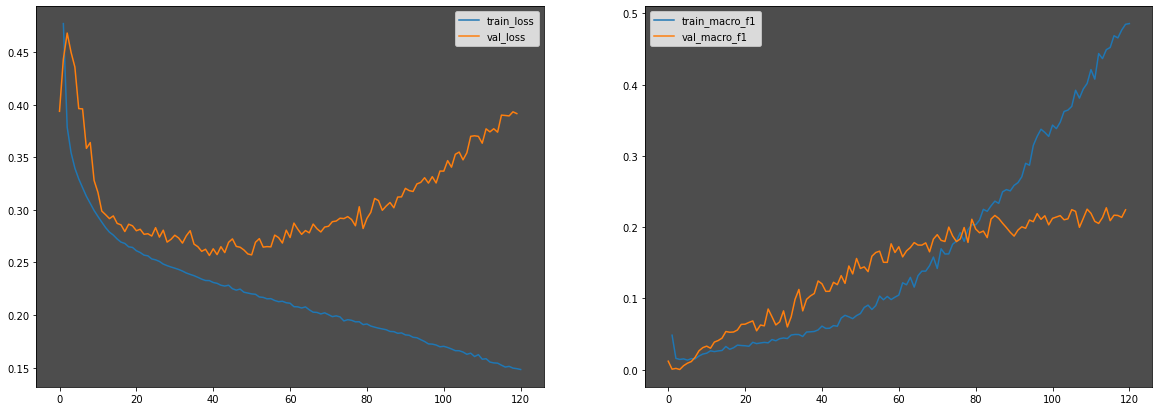

In [18]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(1,epochCount+1), history.history['loss'], range(1,epochCount+1), history.history['val_loss'])
ax.set_facecolor('0.3')
ax.legend(['train_loss', 'val_loss'])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(range(1,epochCount+1), history.history['macro_f1'], range(1,epochCount+1), history.history['val_macro_f1'])
ax2.set_facecolor('0.3')
ax2.legend(['train_macro_f1', 'val_macro_f1'])
plt.show()

We will save the model in h5 format.

In [0]:
model1.save('from_scratch_model.h5')

### Transfer learning

For transfer learning we start with a MobileNetV2 CNN that was trained on the ImageNet data set. We remove the classification top and retain the convolutional layers. We already see there are a lot more parameters than in our basic model that we trained from scratch.

In [20]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

We will freeze all parameters in the base model and add some layers to be able to do the classification. We add a global average pooling layer to flatten (and average over) the output of the last layer in the base model. We add a dense layer of 1024 hidden nodes that will do the classification together with the last layer of 20 nodes, representing the 20 classes.

In [21]:
base_model.trainable = False
model2 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  tf.keras.layers.Dense(20, activation='sigmoid')
])
# Renaming this layer because of naming conventions
model2.get_layer('mobilenetv2_1.00_224')._name = 'mobilenet'
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet (Model)            (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                20500     
Total params: 3,590,228
Trainable params: 1,332,244
Non-trainable params: 2,257,984
_________________________________________________________________


We will compile this model. We will use the Adam optimizer with a learning rate of 1e-4 and the metrics and loss function we discussed before. 

In [0]:
LR = 1e-4
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

We will train this model for 20 epochs on our training data. Only the classification part of the model will be trained now.

In [23]:
epochCount = 20
history1 = model2.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/20
35/35 [==============================] - 13s 363ms/step - loss: 0.2989 - macro_f1: 0.0544 - true_positives_1: 737.0000 - true_negatives_1: 61742.0000 - false_positives_1: 2390.0000 - false_negatives_1: 4591.0000 - val_loss: 0.2091 - val_macro_f1: 0.0431 - val_true_positives_1: 734.0000 - val_true_negatives_1: 66153.0000 - val_false_positives_1: 83.0000 - val_false_negatives_1: 4650.0000
Epoch 2/20
35/35 [==============================] - 11s 319ms/step - loss: 0.1853 - macro_f1: 0.1880 - true_positives_1: 1390.0000 - true_negatives_1: 63913.0000 - false_positives_1: 219.0000 - false_negatives_1: 3938.0000 - val_loss: 0.1632 - val_macro_f1: 0.3068 - val_true_positives_1: 1754.0000 - val_true_negatives_1: 66136.0000 - val_false_positives_1: 100.0000 - val_false_negatives_1: 3630.0000
Epoch 3/20
35/35 [==============================] - 11s 316ms/step - loss: 0.1479 - macro_f1: 0.4246 - true_positives_1: 2257.0000 - true_negatives_1: 63874.0000 - false_positives_1: 258.0000 - fa

Let's plot the evolution of the loss and F1 scores during training. After just 3 epochs our loss and F1 score becomes better than in the previous model, that was trained from scratch. After 20 epochs both loss and F1 seem to stagnate on the validation set.

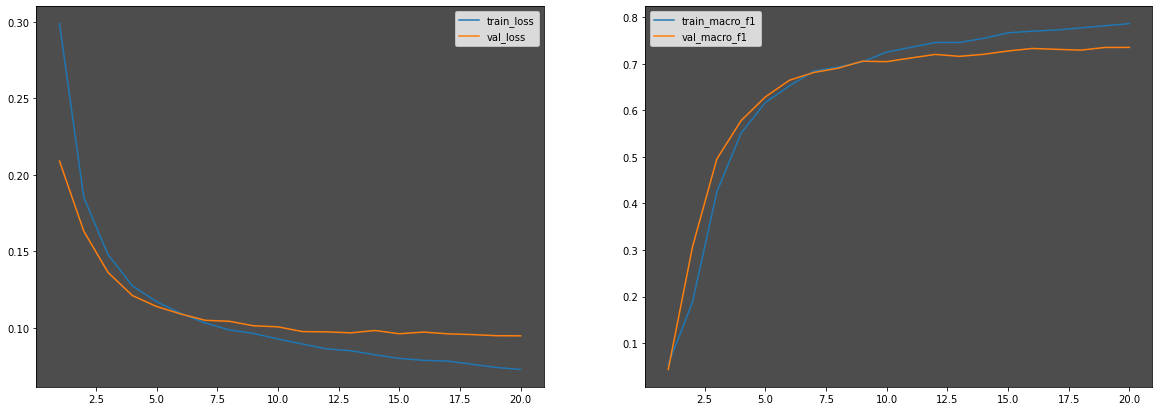

In [28]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(1,epochCount+1), history1.history['loss'], range(1,epochCount+1), history1.history['val_loss'])
ax.set_facecolor('0.3')
ax.legend(['train_loss', 'val_loss'])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(range(1,epochCount+1), history1.history['macro_f1'], range(1,epochCount+1), history1.history['val_macro_f1'])
ax2.set_facecolor('0.3')
ax2.legend(['train_macro_f1', 'val_macro_f1'])
plt.show()

Now, we will unfreeze some of the convolutional layers as well to do some fine tuning. A lot more parameters become trainable.

In [29]:
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet (Model)            (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                20500     
Total params: 3,590,228
Trainable params: 3,194,836
Non-trainable params: 395,392
_________________________________________________________________


As before, we will compile this model. Now, we will decrease the learning rate by a factor 10 to stabilize the learning, since we are training a lot more parameters now.

In [0]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR/10), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

We will fine tune this model for 15 epochs.

In [31]:
epochCount = 15
history2 = model2.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/15
35/35 [==============================] - 13s 374ms/step - loss: 0.0918 - macro_f1: 0.7112 - true_positives_2: 3377.0000 - true_negatives_2: 63786.0000 - false_positives_2: 346.0000 - false_negatives_2: 1951.0000 - val_loss: 0.0913 - val_macro_f1: 0.7519 - val_true_positives_2: 3844.0000 - val_true_negatives_2: 65567.0000 - val_false_positives_2: 669.0000 - val_false_negatives_2: 1540.0000
Epoch 2/15
35/35 [==============================] - 12s 341ms/step - loss: 0.0817 - macro_f1: 0.7515 - true_positives_2: 3678.0000 - true_negatives_2: 63719.0000 - false_positives_2: 413.0000 - false_negatives_2: 1650.0000 - val_loss: 0.0909 - val_macro_f1: 0.7548 - val_true_positives_2: 3871.0000 - val_true_negatives_2: 65554.0000 - val_false_positives_2: 682.0000 - val_false_negatives_2: 1513.0000
Epoch 3/15
35/35 [==============================] - 12s 339ms/step - loss: 0.0776 - macro_f1: 0.7724 - true_positives_2: 3801.0000 - true_negatives_2: 63739.0000 - false_positives_2: 393.0000 - 

Let's visualise the loss and F1 score for this second part of training. We see that this fine tuning slightly increased the performance on the validation set, but also starts overfitting.

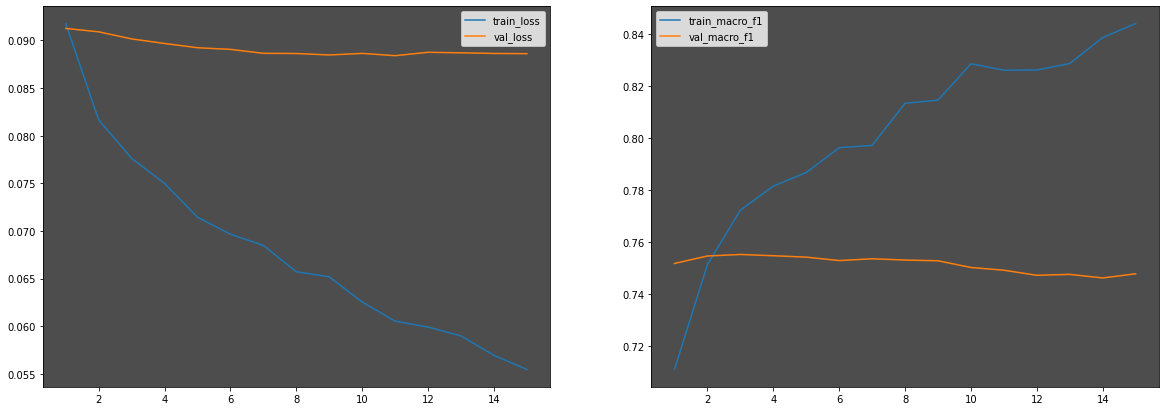

In [32]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(1,epochCount+1), history2.history['loss'], range(1,epochCount+1), history2.history['val_loss'])
ax.set_facecolor('0.3')
ax.legend(['train_loss', 'val_loss'])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(range(1,epochCount+1), history2.history['macro_f1'], range(1,epochCount+1), history2.history['val_macro_f1'])
ax2.set_facecolor('0.3')
ax2.legend(['train_macro_f1', 'val_macro_f1'])
plt.show()

We will also save this model in h5 format.

In [0]:
model2.save('transfer_learning_model.h5')

## Explore results

After training, we will explore the results of our models. The first model, trained from scratch, does not achieve very good results. It is limited in what it can express and also would require more data to get a better accuracy. 

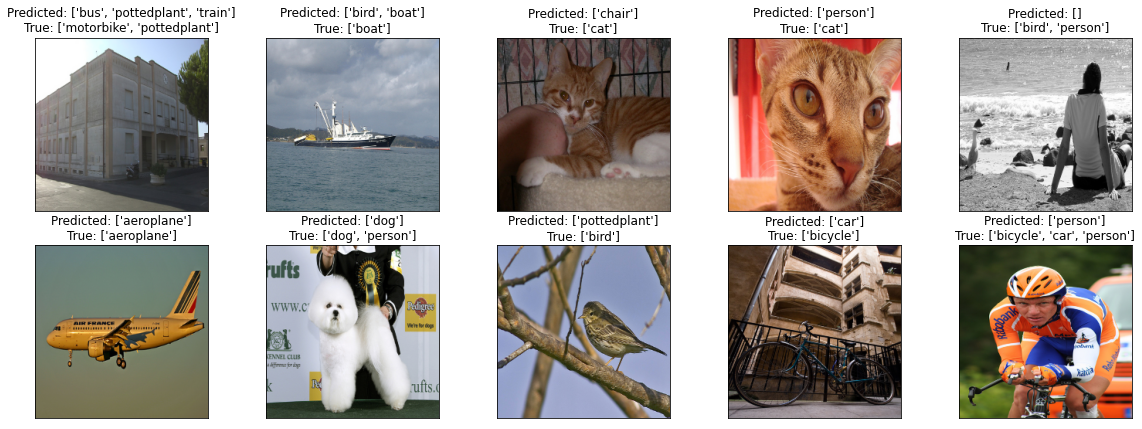

In [34]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = decode(np.around(model1(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = decode(np.around(model1(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

We achieve better results with our second model.

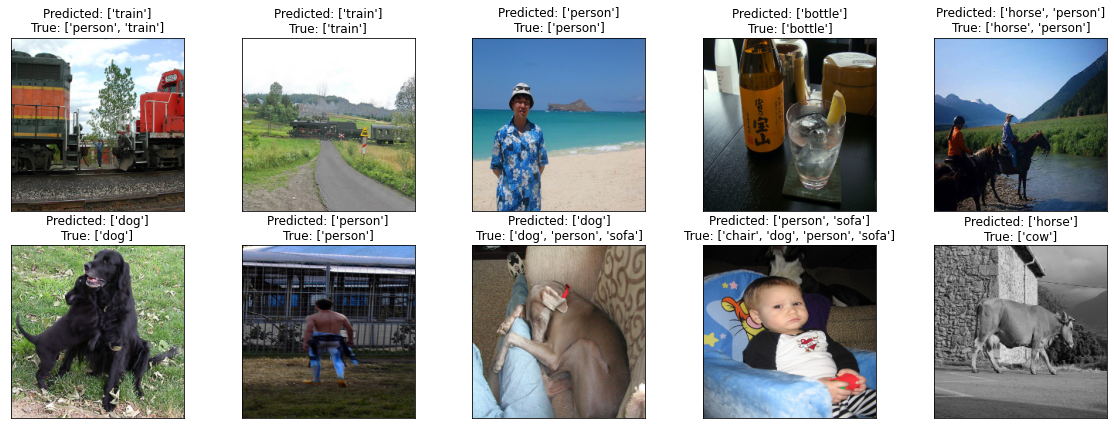

In [42]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = decode(np.around(model2(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = decode(np.around(model2(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

Some confusion occurs in the algorithm because we are doing multilabel classification instead of detection. The algorithm seems to get confused sometimes because it does not always find the exact area in the picture to which the label belongs. Typical cases are predicting a person and a bike, when only a bike is visible in the picture, probably because in most pictures these occur together (and also because people are occurring very often in the datast), which might confuse the algorithm. 

We will further look at the results of the second model (created using transfer learning) on the entire validation set.

In [0]:
result = model2.predict(validation_batches)

We will calculate and plot the F1 score for each class separately and see what we can find.

In [0]:
y_pred = tf.cast(tf.greater(result, 0.5), tf.float32)
tp = tf.cast(tf.math.count_nonzero(y_pred * y_val, axis=0), tf.float32)
fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_val), axis=0), tf.float32)
tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y_val), axis=0), tf.float32)
fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_val, axis=0), tf.float32)
f1 = 2* tp / (2 * tp + fn + fp + 1e-16)

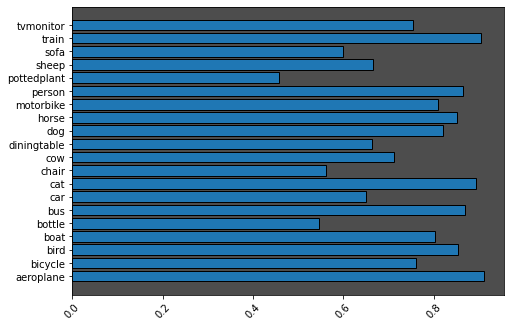

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, f1, linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

Since it is plausible that it is harder to train the multilabel classification for classes that often occur together with other classes (as opposed to occurring alone in an image), we plot the percentage of occurrences for each class that occurs alone in an image.

In [0]:
lonely_y = y_train[np.sum(y_train, axis=1) == 1]

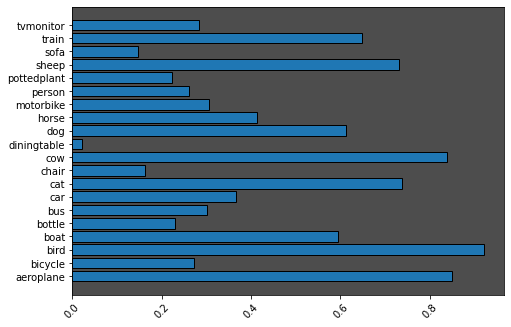

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, sum(lonely_y) / sum(y_train), linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

It is easy to get good results for person, since that often occurs in the images.
There is a good F1 score for aeroplanes, which seems explainable because there are quite some aeroplanes in the dataset and they often occur alone in an image, making them easier to train and easier to recognize.
Potted plants perform the worst, probably because they have a wide variety of appearances, often occur together with other objects in the image (and are often the smaller ones) and don't occur in the training set a lot.
Bottles have similar problems to be recognized, but have a more recognizable appearance, so have a slightly better score.
Chairs and sofas often occur together with other objects in the image, but are also often occluded by those other objects, making them harder to predict as well.

To improve the results, we could find additional data, or augment the current data in other ways (translations, cropping, etc. ...). Another option that might improve results is to use the F1 score as a loss function.